# 설정

In [1]:
# 파이썬 ≥ 3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥ 0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 캐글 신용카드 사기 검출

이번에는 Kaggle의 신용카드 데이터 세트를 이용해 신용카드 사기 검출 분류 실습을 수행해 보겠다. 해당 데이터 세트의 레이블인 Class 속성은 매우 불균형한 분포를 가지고 있다. Class는 0과 1로 분류되는데 0이 사기가 아닌 정상적인 신용카드 트랜잭션 데이터, 1은 신용카드 사기 트랜잭션을 의미한다. 전체 데이터의 약 0.172%만이 레이블 값이 1, 즉 사기 트랜잭션이다. 일반적으로 사기 검출<sup>Fraud Detection</sup>이나 이상 검출<sup>Anomaly Detection</sup>과 같은 데이터 세트는 이처럼 레이블 값이 극도로 불균형한 분포를 가지기 쉽다. 왜냐하면 사기와 같은 이상 현상은 전체 데이터에서 차지하는 비중이 매우 적을 수밖에 없기 때문이다.

## 언더 샘플링과 오버 샘플링의 이해

레이블이 불균형한 분포를 가진 데이터 세트를 학습시킬 때 예측 성능의 문제가 발생할 수 있는데, 이는 이상 레이블을 가지는 데이터 건수가 정상 레이블을 가진 데이터 건수에 비해 너무 적기 때문에 발생한다. <u>즉 이상 레이블을 가지는 데이터 건수는 매우 적기 때문에 제대로 다양한 유형을 학습하지 못하는 반면에 정상 레이블을 가지는 데이터 건수는 매우 많이 때문에 일방적으로 정상 레이블로 치우친 학습을 수행해 제대로 된 이상 데이터 검출이 어려워지기 쉽다.</u> 지도학습에서 극도로 불균형한 레이블 값 분포로 인한 문제점을 해결하기 위해서는 적절한 학습 데이터를 확보하는 방안이 필요한데, 대표적으로 <u>오버 샘플링<sup>Oversampling</sup></u>과 <u>언더 샘플링<sup>Undersampling</sup></u> 방법이 있으며, 오버 샘플링 방식이 예측 성능상 더 유리한 경우가 많아 주로 사용된다.

<b>그림 1</b> 언더 샘플링과 오버 샘플링
<div style="text-align:center;">
    <img src="./under_over.png">
</div>

<ul>
    <li>언더 샘플링은 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식이다. 즉 정상 레이블을 가진 데이터가 10,000건, 이상 레이블을 가진 데이터가 100건이 있으면 정상 레이블 데이터를 100건으로 줄여 버리는 방식이다. 이렇게 정상 레이블 데이터를 이상 레이블 데이터 수준으로 줄여 버린 상태에서 학습을 수행하면 과도하게 정상 레이블로 학습/예측하는 부작용을 개선할 수 있지만, 너무 많은 정상 레이블 데이터를 감소시키기 때문에 정상 레이블의 경우 오히려 제대로 된 학습을 수행할 수 없다는 단점이 있어 잘 적용하지 않는 방법이다.</li>
    <li>오버 샘플링은 이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법이다. 동일한 데이터를 단순히 증식하는 방법은 과대적합<sup>Overfitting</sup>이 되기 때문에 의미가 없으므로 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식한다. 대표적으로 SMOTE<sup>Synthetic Minority Over-sampling Technique</sup> 방법이 있다. SMOTE는 적은 데이터 세트에 개별 데이터들의 K 최근접 이웃<sup>K Nearest Neightbor</sup>을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식이다.</li>
</ul>

<b>그림 2</b> SMOTE 수행 절차
<div style="text-align:center;">
    <img src="./SMOTE.png">
</div>

SMOTE를 구현한 대표적인 파이썬 패키지는 imbalanced-learn이다. 이번 절에서는 이를 이용해 데이터를 증식해 보겠다.

## 데이터 일차 가공 및 모델 학습/예측/평가

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('./creditcard.csv/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


creditcard.csv의 V로 시작하는 피처들의 의미는 알 수가 없다. Time 피처의 경우는 데이터 생성 관련한 작업용 속성으로서 큰 의미가 없기에 제거하겠다. Amount 피처는 신용카드 트랜잭션 금액을 의미하며, Class는 레이블로서 0의 경우 정상, 1의 경우 사기 트랜잭션이다. <code>card_df.info()</code>로 확인해 보면 전체 284,807개의 레코드에서 결측치<sup>Missing Value</sup> 값은 없으며, Class 레이블만 int 형이고 나머지 피처들은 모두 float형이다.

이번 실습에서는 보다 다양한 데이터 사전 가공을 수행하고, 이에 따른 예측 성능도 함께 비교해 보겠다. 이를 위해 인자로 입력된 DataFrame을 복사한 뒤, 이를 가공하여 반환하는 <code>get_preprocessed_df()</code> 함수와 데이터 가공 후 학습/테스트 데이터 세트를 반환하는 <code>get_train_test_df()</code> 함수를 생성하겠다. 먼저 <code>get_preprocessed_df()</code> 함수는 불필요한 Time 피처만 삭제하는 것으로부터 시작하겠다.

In [3]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

<code>get_train_test_dataset()</code>는 <code>get_preprocessed_df()</code>를 호출한 뒤 학습 피처/레이블 데이터 세트, 테스트 피처/레이블 데이터 세트를 반환한다. <code>get_train_test_dataset()</code>는 내부에서 <code>train_test_split()</code> 함수를 호출하며, 테스트 데이터 세트를 전체의 30%인 Stratified 방식으로 추출해 학습 데이터 세트와 테스트 데이터 세트의 리에블 값 분포도를 서로 동일하게 만든다.

In [4]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split()으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test =\
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

생성한 학습 데이터 세트와 테스트 데이터 세트의 레이블 값 비율을 백분율로 환산해서 서로 비슷하게 분할됐는지 확인해 보겠다.

In [5]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts(normalize=True))
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts(normalize=True))

학습 데이터 레이블 값 비율
0    0.998275
1    0.001725
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    0.998268
1    0.001732
Name: Class, dtype: float64


학습 데이터 레이블의 경우 1값이 0.172%, 테스트 데이터 레이블의 경우 1값이 0.173%로 큰 차이가 없이 잘 분할됐다. 이제 모델을 만들어 보겠다. 로지스틱 회귀와 LightGBM 기반의 모델이 데이터 가공을 수행하면서 예측 성능이 어떻게 변하는지 살펴볼 것이다. 먼저 로지스틱 회귀를 이용해 신용 카드 사기 여부를 예측해 보겠다.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,\
                            recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, y_pred, y_pred_proba=None):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_score = roc_auc_score(y_test, y_pred_proba)
    
    print('오차 행렬')
    print(confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}".\
         format(accuracy, precision, recall, f1, roc_score))

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85282    13]
 [   62    86]]
정확도: 0.9991, 정밀도: 0.8687, 재현율: 0.5811, F1: 0.6964, AUC: 0.9556


테스트 데이터 세트로 측정 시 재현율<sup>Recall</sup>이 0.5811, ROC-AUC가 0.9556이다. 이번에는 LightGBM을 이용한 모델을 만들어 보겠다. 그에 앞서, 앞으로 수행할 예제 코드에서 반복적으로 모델을 변경해 학습/예측/평가할 것이므로 이를 위한 별도의 함수를 생성하겠다. <code>get_model_train_eval()</code>는 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가를 수행하는 역할을 하는 함수다.

In [7]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

먼저, 본 데이터 세트는 극도로 불균형한 레이블 값 분포도를 가지고 있으므로 LGBMClassifier 객체 생성 시 boost_from_average=False로 파라미터를 설정해야 한다.

LightGBM으로 모델을 학습한 뒤, 별도의 테스트 데이터 세트에서 예측 평가를 수행해 보겠다.

In [8]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568, F1: 0.8453, AUC: 0.9790


재현율 0.7568, ROC-AUC 0.9790로 앞의 로지스틱 회귀보다는 높은 수치를 나타냈다.

## 데이터 분포도 변환 후 모델 학습/예측/평가

이번에는 왜곡된 분포도를 가지는 데이터를 재가공한 뒤에 모델을 다시 테스트해 보겠다. 먼저 creditcard.csv의 중요 피처 값의 분포도를 살펴본다. 로지스틱 회귀는 선형 모델이다. 대부분의 선형 모델은 중요 피처들의 값이 정규 분포 형태를 유지하는 것을 선호한다. Amount 피처는 신용 카드 사용 금액으로 정상/사기 트랜잭션을 결정하는 매우 중요한 속성일 가능성이 높다. Amount 피처의 분포도를 확인해 보겠다.

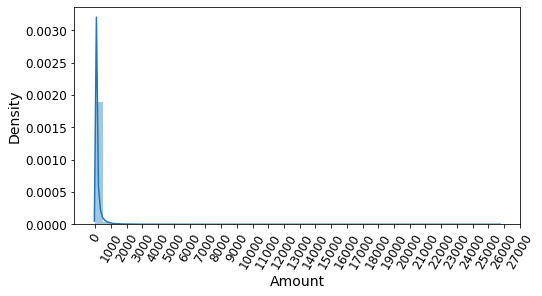

In [9]:
import seaborn as sns
plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])
plt.show()

Amount, 즉 카드 사용금액이 1000불 이하인 데이터가 대부분이며, 27,000불까지 드물지만 많은 금액을 사용한 경우가 발생하면서 꼬리가 긴 형태의 분포 곡선을 가지고 있다. Amount를 표준 정규 분포 형태로 변환한 뒤에 로지스틱 회귀의 예측 성능을 측정해 보겠다. 이를 위해 앞에서 만든 <code>get_processed_df()</code> 함수를 다음과 같이 사이킷런의 StandardScaler 클래스를 이용해 Amount 피처를 정규 분포 형태로 변환하는 코드로 변경한다.

In [10]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정.
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

함수를 수정한 후 <code>get_train_test_dataset()</code>를 호출해 학습/테스트 데이터 세트를 생성한 후에 <code>get_model_train_eval()</code>를 이용해 로지스틱 회귀와 LightGBM 모델을 각각 학습/예측/평가 해보겠다.

In [11]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, AUC: 0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500, F1: 0.8409, AUC: 0.9779


정규 분포 형태로 Amount 피처값을 변환한 후 테스트 데이터 세트에 적용한 로지스틱 회귀 및 LightGBM 두 모델 모두 변환 이전과 비교해 성능이 크게 개선되지는 않았다.

이번에는 StandardScaler가 아니라 로그 변환을 수행해 보겠다. 로그 변환은 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중에 하나다. 원래 값을 log 값으로 변환해 원래 큰 값을 상대적으로 작은 값으로 변환하기 때문에 데이터 분포도의 왜곡을 상당 수준 개선해 준다. 로그 변환은 넘파이의 <code>log1p()</code> 함수를 이용해 간단히 변환이 가능하다. 데이터 가공 함수인 <code>get_preprocessed_df()</code>를 다음과 같이 로그 변환 로직으로 변경한다.

In [12]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p()를 이용해 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

이제 Amount 피처를 로그 변환한 후 다시 로지스틱 회귀와 LightGBM 모델을 적용한 후 예측 성능을 확인해 보겠다.

In [13]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, AUC: 0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635, F1: 0.8496, AUC: 0.9796


두 모델 모두 정밀도, 재현율, ROC-AUC에서 약간씩 성능이 개선되었음을 나타내고 있다.

## 이상치 데이터 제거 후 모델 학습/예측/평가

이상치 데이터<sup>Outlier</sup>는 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터이며, 아웃라이어라고도 불린다. 이상치로 인해 머신러닝 모델의 성능에 영향을 받는 경우가 발생하기 쉽다. 이번에는 이러한 이상치를 찾아내는 방법을 소개하고, 이들 데이터를 제거한 뒤에 다시 모델을 평가해 보겠다. 이상치를 찾는 방법은 여러 가지가 있지만, 이 중에서 IQR<sup>Inter Quantile Range</sup> 방식을 적용해 보겠다. IQR은 사분위<sup>Quantile</sup> 값의 편차를 이용하는 기법으로 흔히 박스 플롯<sup>Box plot</sup> 방식으로 시각화할 수 있다.

먼저 사분위에 대해 알아보자. 사분위는 전체 데이터를 값이 높은 순으로 정렬하고, 이를 1/4(25%)씩으로 구간을 분할하는 것을 지칭한다. 가령 100명의 시험 성적이 0점부터 100점까지 있다면, 이를 100등부터 1등까지 성적순으로 정렬한 뒤에 1/4 구간으로 Q1, Q2, Q3, Q4와 같이 나누는 것이다. 이들 중 25% 구간인 Q1 ~ 75% 구간인 Q3의 범위를 IQR이라고 한다. 다음 그림은 사분위와 IQR을 표현한 것이다.

<b>그림 3</b> 사분위수
<div style="text-align:center;">
    <img src="./사분위수.png">
</div>

IQR을 이용해 이상치 데이터를 검출하는 방식은 보통 IQR에 1.5를 곱해서 생성된 범위를 이용해 최댓값과 최솟값을 결정한 뒤 최댓값을 초과하거나 최솟값에 미달하는 데이터를 이상치로 간주하는 것이다. 3/4 분위수(Q3)에 IQR * 1.5를 더해서 일반적인 데이터가 가질 수 있는 최댓값으로 가정하고, 1/4 분위수(Q1)에 IQR * 1.5를 빼서 일반적인 데이터가 가질 수 있는 최솟값으로 가정한다. 경우에 따라서 1.5가 아닌 다른 값을 적용할 수도 있으며, 보통은 1.5를 적용한다. 이렇게 결정된 최댓값보다 큰 값 또는 최솟값보다 작은 값을 이상치 데이터로 간주한다. IQR 방식을 시각화한 도표가 박스 플롯이다. 박스 플롯은 다음과 같은 표현 방식으로 사분위의 편차와 IQR, 그리고 이상치를 나타낸다.

<b>그림 4</b> box plot
<div style="text-align:center;">
    <img src="./box_plot.png">
</div>

이제 이상치 데이터를 IQR을 이용해 제거해 보겠다. 먼저 어떤 피처의 이상치 데이터를 검출할 것인지 선택이 필요하다. 매우 많은 피처가 있을 경우 이들 중 결정값(즉 레이블)과 가장 상관성이 높은 피처들을 위주로 이상치를 검출하는 것이 좋다. 모든 피처들의 이상치를 검출하는 것은 시간이 많이 소모되며, 결정값과 상관성이 높지 않은 피처들의 경우는 이상치를 제거하더라도 크게 성능 향상에 기여하지 않기 때문이다. DataFrame의 <code>corr()</code>을 이용해 각 피처별로 상관도를 구한 뒤 시본의 heatmap을 통해 시각화해 보겠다.

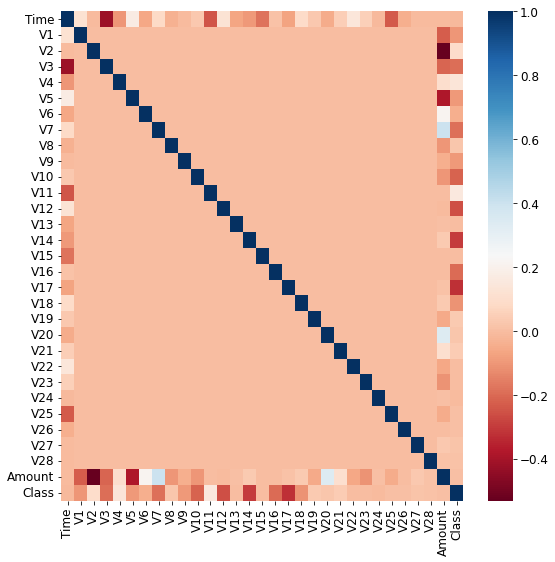

In [14]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap="RdBu")
plt.show()

상관관계 히트맵에서 camp을 'RdBu'로 설정해 양의 상관관계가 높을수록 색깔이 진한 파란색에 가까우며, 음의 상관관계가 높을수록 색깔이 진한 빨간색에 가깝게 표현된다. 상관관계 히트맵에서 맨 아래에 위치한 결정 레이블인 Class 피처와 음의 상관관계가 가장 높은 피처는 V14와 V17이다. 이 중 V14에 대해서만 이상치를 찾아서 제거해 보겠다. IQR을 이용해 이상치를 검출하는 함수를 생성한 뒤, 이를 이용해 검출된 이상치를 삭제한다. <code>get_outlier()</code> 함수는 인자로 DataFrame과 이상치를 검출할 칼럼을 입력 받는다. 함수 내에서 넘파이의 <code>percentile()</code>을 이용해 1/4 분위와 3/4 분위를 구하고, 이에 기반해 IQR을 계산한다. 계산된 IQR에 1.5를 곱해서 최댓값과 최솟값 지점을 구한 뒤, 최댓값보다 크거나 최솟값보다 작은 값을 이상치로 설정하고 해당 이상치가 있는 DataFrame Index를 반환한다.

In [15]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함.
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함.
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환.
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

<code>get_outlier()</code> 함수를 이용해 V14 칼럼에서 이상치 데이터를 찾아보겠다.

In [16]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


총 4개의 데이터인 8296, 8615, 9035, 9252번 Index가 이상치로 추출됐다. <code>get_outlier()</code>를 이용해 이상치를 추출하고 이를 삭제하는 로직을 <code>get_processed_df()</code> 함수에 추가해 데이터를 가공한 뒤 이 데이터 세트를 이용해 로지스틱 회귀와 LightGBM 모델을 다시 적용해 보겠다.

In [17]:
# get_preprocessed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경.
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC: 0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288, F1: 0.8897, AUC: 0.9780


이상치 데이터를 제거한 뒤, 로지스틱 회귀와 LightGBM 모두 예측 성능이 크게 향상되었다. 로지스틱 회귀의 경우 재현율이 60.14%에서 67.12%로 크게 증가했으며, LightGBM의 경우도76.35%에서 82.88%로 역시 크게 증가했다.

## SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

이번에는 SMOTE 기법으로 오버 샘플링을 적용한 뒤 로지스틱 회귀나 LightGBM 모델의 예측 성능을 평가해 보겠다. 먼저 SMOTE는 imbalanced-learn 패키지의 SMOTE 클래스를 이용해 간단하게 구현이 가능하다. SMOTE를 적용할 때는 반드시 학습 데이터 세트만 오버 샘플링을 해야 한다. 검증 데이터 세트나 테스트 데이터 세트를 오버 샘플링할 경우 결국은 원본 데이터 세트가 아닌 데이터 세트에서 검증 또는 테스트를 수행하기 때문에 올바른 검증/테스트가 될 수 없다.

앞 예제에서 생성한 학습/피처 레이블 데이터를 SMOTE 객체의 <code>fit_resample()</code> 메서드를 이용해 증식한 뒤 데이터를 증식 전과 비교해 보겠다.

In [20]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


SMOTE 적용 전 학습 데이터 세트는 199,362건이었지만 SMOTE 적용 후 2배에 가까운 398,040건으로 데이터가 증식됐다. 그리고 SMOTE 적용 후 레이블 값이 0과 1의 분포가 동일하게 199,020 건으로 생성됐다. 이제 이렇게 생성된 학습 데이터 세트를 기반으로 먼저 로지스틱 회귀 모델을 학습한 뒤 성능을 평가해 보겠다.

In [21]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, X_train_over, X_test, y_train_over, y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, F1: 0.1023, AUC: 0.9737


로지스틱 회귀 모델의 경우 SMOTE로 오버 샘플링된 데이터로 학습할 경우 재현율이 92.47%로 크게 증가하지만, 반대로 정밀도가 5.4%로 급격하게 저하된다. 재현율이 높더라도  이 정도로 저조한 정밀도로는 현실 업무에 적용할 수 없다. 이는 로지스틱 회귀 모델이 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무나 많은 Class=1 데이터를 학습하면서 실제 테스트 데이터 세트에서 예측을 지나치게 Class=1로 적용해 정밀도가 급격히 떨어지게 된 것이다. 분류 결정 임곗값에 따른 정밀도와 재현율 곡선을 통해 SMOTE로 학습된 로지스틱 회귀 모델에 어떠한 문제가 발생하고 있는지 시각적으로 확인해 보겠다.

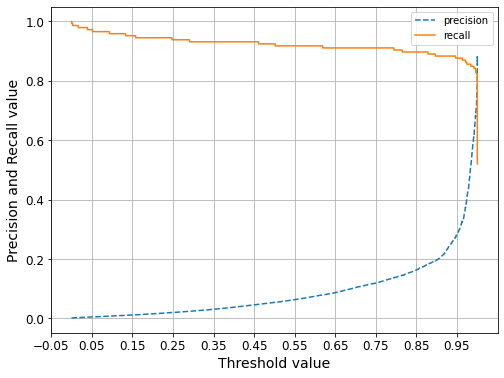

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, lr_clf.predict_proba(X_test)[:, 1])

# X축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
plt.figure(figsize=(8, 6))
threshold_boundary = thresholds.shape[0]
plt.plot(thresholds, precisions[:threshold_boundary], linestyle='--', label='precision')
plt.plot(thresholds, recalls[:threshold_boundary], label='recall')

# threshold 값 X축의 Scale을 0.1 단위로 변경
start, end = plt.xlim()
plt.xticks(np.round(np.arange(start, end, 0.1), 2))

# x축, y축 label과 legend, 그리고 grid 설정
plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
plt.legend(); plt.grid()
plt.show()

임계값이 0.99 이하에서는 재현율이 매우 좋고 정밀도가 극단적으로 낮다가 0.99 이상에서는 반대로 재현율이 대폭 떨어지고 정밀도가 높아진다. 분류 결정 임곗값을 조정하더라도 임곗값의 민감도가 너무 심해 올바른 재현율/정밀도 성능을 얻을 수 없으므로 로지스틱 회귀 모델의 경우 SMOTE 적용 후 올바른 예측 모델이 생성되지 못했다. 이번에는 LightGBM 모델을 SMOTE로 오버 샘플링된 데이터 세트로 학습/예측/평가를 수행하겠다.

In [30]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train_over, X_test, y_train_over, y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493, F1: 0.8794, AUC: 0.9814


재현율이 이상치만 제거한 경우인 82.88%보다 높은 84.93%가 되었다. 그러나 정밀도는 이전의 96.03%보다 낮은 91.18%이다. SMOTE를 적용하면 재현율은 높아지나, 정밀도가 낮아지는 것이 일반적이다. 좋은 SMOTE 패키지일수록 재현율 증가율은 높이고 정밀도 감소율은 낮출 수 있도록 효과적으로 데이터를 증식한다.

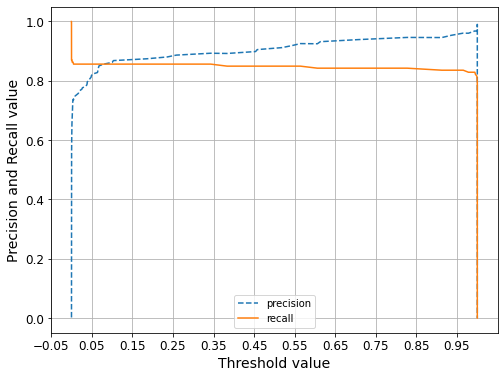

In [34]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, lgbm_clf.predict_proba(X_test)[:, 1])

# X축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
plt.figure(figsize=(8, 6))
threshold_boundary = thresholds.shape[0]
plt.plot(thresholds, precisions[:threshold_boundary], linestyle='--', label='precision')
plt.plot(thresholds, recalls[:threshold_boundary], label='recall')

# threshold 값 X축의 Scale을 0.1 단위로 변경
start, end = plt.xlim()
plt.xticks(np.round(np.arange(start, end, 0.1), 2))

# x축, y축 label과 legend, 그리고 grid 설정
plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
plt.legend(); plt.grid()
plt.show()